In [17]:
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
import pybedtools
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

In [4]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Browser shot

In [7]:
def plot_example(title, region, outputfile):
	ks = ["pl", "mn"]
	data = {
			"PRO-cap (rep1)": [f"{PROJECT_DIR_d}Alignments/C1a_5{k}.bw" for k in ks],
			"PRO-cap (rep2)": [f"{PROJECT_DIR_d}Alignments/C1b_5{k}.bw" for k in ks],
			"DNase": f"{PROJECT_DIR_r}ENCODE/ENCFF414OGC.bigWig",
			"H3K27ac": f"{PROJECT_DIR_r}ENCODE/ENCFF849TDM.bigWig"
			}
	formatters = {
			"PRO-cap (rep1)": {"yscale":"asym_pos_neg", "plot_kw":{"width":3}},
			"PRO-cap (rep2)": {"yscale":"asym_pos_neg", "plot_kw":{"width":3}},
			"DNase": {"plot_kw": {"fill_kw":{"color":"#B3DE69"}}},
			"H3K27ac": {"plot_kw": {"fill_kw":{"color":"#FFD700"}}},
			}
	height_ratios = {
			"PRO-cap (rep1)": 8,
			"PRO-cap (rep2)": 8,
			"DNase": 5,
			"H3K27ac": 5
			}
	
	fig = gv.plot_genome_view(
		region,
		data = data,
		formatters = formatters,
		height_ratios = height_ratios,
		group_autoscales = [["PRO-cap (rep1)", "PRO-cap (rep2)"]],
		coordinate_kw = {"major_coordinate_unit":150}
		)
	
	bpu.plt_change_figure_properties(
		fig,
		**{"fig_prop": {"size_inches":[2.8, 1.9]},
		"fig_suptitle": title,
		"fig_suptitle_kwargs": {"fontsize":bfontsize},
		"xticklabels_prop": {"fontsize":sfontsize},
		"yticklabels_prop": {"fontsize":sfontsize},
		"ylabel_prop": {"fontsize":bfontsize},
		"xlabel_prop": {"fontsize":bfontsize}
		},
		title_prop = {"text": ""}
		)

	bpu.plt_change_figure_properties(
		fig, 
		ax_targets=[-1],
		xlabel_prop={"text":f"Genomic position ({region.split(':')[0]})"}
		)

	for i in range(len(data)):
		fig.axes[i].yaxis.set_label_coords(-0.21, 0.5)
		fig.axes[i].yaxis.set_major_formatter(lambda s, pos: f"{s:.0f}")
		
	fig.savefig(outputfile, bbox_inches="tight", transparent=True)

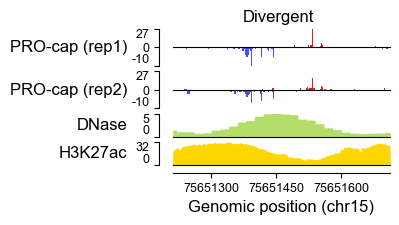

In [8]:
# Example divergent element

title = "Divergent"
region = "chr15:75651212-75651713"
outputfile = f"{PROJECT_DIR_o}figures/Fig1a.top.pdf"
plot_example(title, region, outputfile)

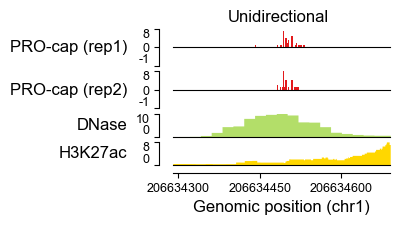

In [9]:
# Example unidirectional element

title = "Unidirectional"
# chr1:206634239-206634740
region = "chr1:206634290-206634690"
outputfile = f"{PROJECT_DIR_o}figures/Fig1a.bottom.pdf"
plot_example(title, region, outputfile)

In [19]:
# Based on browser shots, it seems unidirectional TSSs are closer to the center
# Check if there is such a pattern 

ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
results = []
for p, d in itertools.product(ps, ds):
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/C1_{p}_{d}.bed")
	for i in b:
		center = (int(i.fields[1])+int(i.fields[2]))//2
		tss = int(i.fields[-3])
		distance = abs(tss-center)
		results.append([p.capitalize(), d.capitalize(), distance])
df_distance = pd.DataFrame(results, columns=["group1", "group2", "distance"])

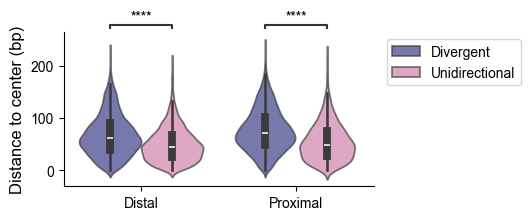

In [30]:
fig, ax = plt.subplots(figsize=(4,2))
hue_plot_params = {
					"data": df_distance,
					"x": "group2",
					"y": "distance",
				    "palette": ["#313695", "#de77ae"],
					"hue": "group1",
					"alpha": 0.7					
				}
g = sns.violinplot(ax=ax, **hue_plot_params)

g.set_xlabel("")
g.set_ylabel("Distance to center (bp)", fontsize=bfontsize)
g.spines[["top","right"]].set_visible(False)
g.legend(loc="upper left", bbox_to_anchor=(1.02,1))

pairs = []
for d in ds:
	pairs.append([(d.capitalize(), "Divergent"), (d.capitalize(), "Unidirectional")])
annotator = Annotator(g, pairs, **hue_plot_params)
annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=1, text_format="star", verbose=False, loc="outside")
_, results = annotator.apply_and_annotate()